In [1]:
import pandas as pd
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.phrases import Phrases, Phraser
import spacy
import string

import pyLDAvis
import pyLDAvis.gensim
from gensim.utils import lemmatize
from pprint import pprint
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [3]:
covid19 = pd.read_csv("../data/covid19.csv")

In [4]:
covid19_abstract = covid19[['Abstract','Title']].dropna().reset_index(drop = True)

In [5]:
covid19_abstract.head()

,Abstract,Title
0,We presented two cases of COVID-19 associated ...,Perinatal Transmission of COVID-19 Associated ...
1,The current outbreak of Coronavirus Disease 20...,Successful recovery of COVID-19 pneumonia in a...
2,"Since December 2019, world healthcare communit...",Coronavirus Disease 2019 and Transplantation: ...
3,The role of clinical laboratory data in the di...,Diagnostic Utility of Clinical Laboratory Data...
4,The sudden outbreak and spread of COVID-19 in ...,"Under the epidemic situation of COVID-19, shou..."


In [6]:
stop_words = stopwords.words('english')
nlp = spacy.load('en', disable=['parser', 'ner'])
# clean the text using below for loop
clean_text = []
for index in range(len(covid19_abstract)):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', covid19_abstract['Abstract'][index])

    #Convert to lowercase
    text = text.lower()
    
    #remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    #Convert to list of words from text
    text = text.split()
    
    # remove stop words after splitting text and joint the words
    text =[word for word in text if word not in stop_words]
    text = " ".join(text)
    # lemmatize words using spacy
    
    doc = nlp(text)
    text=" ".join([token.lemma_ for token in doc])

   # append to clean_text
    clean_text.append(text)
    
covid19_abstract['clean_text'] = clean_text

In [7]:
covid19_abstract.head()

,Abstract,Title,clean_text
0,We presented two cases of COVID-19 associated ...,Perinatal Transmission of COVID-19 Associated ...,present two case covid associate sars cov infe...
1,The current outbreak of Coronavirus Disease 20...,Successful recovery of COVID-19 pneumonia in a...,current outbreak coronavirus disease covid rai...
2,"Since December 2019, world healthcare communit...",Coronavirus Disease 2019 and Transplantation: ...,since december world healthcare community face...
3,The role of clinical laboratory data in the di...,Diagnostic Utility of Clinical Laboratory Data...,role clinical laboratory datum differential di...
4,The sudden outbreak and spread of COVID-19 in ...,"Under the epidemic situation of COVID-19, shou...",sudden outbreak spread covid spring lead serio...


In [8]:
#cnn_text = cnn_abstract[cnn_abstract.clean_text.str.contains('natural language processing|nlp')]

In [9]:
covid19_abstract.shape

(2233, 3)

In [10]:
covid19_abstract.to_csv('../data/covid_clean_text.csv', index = False)

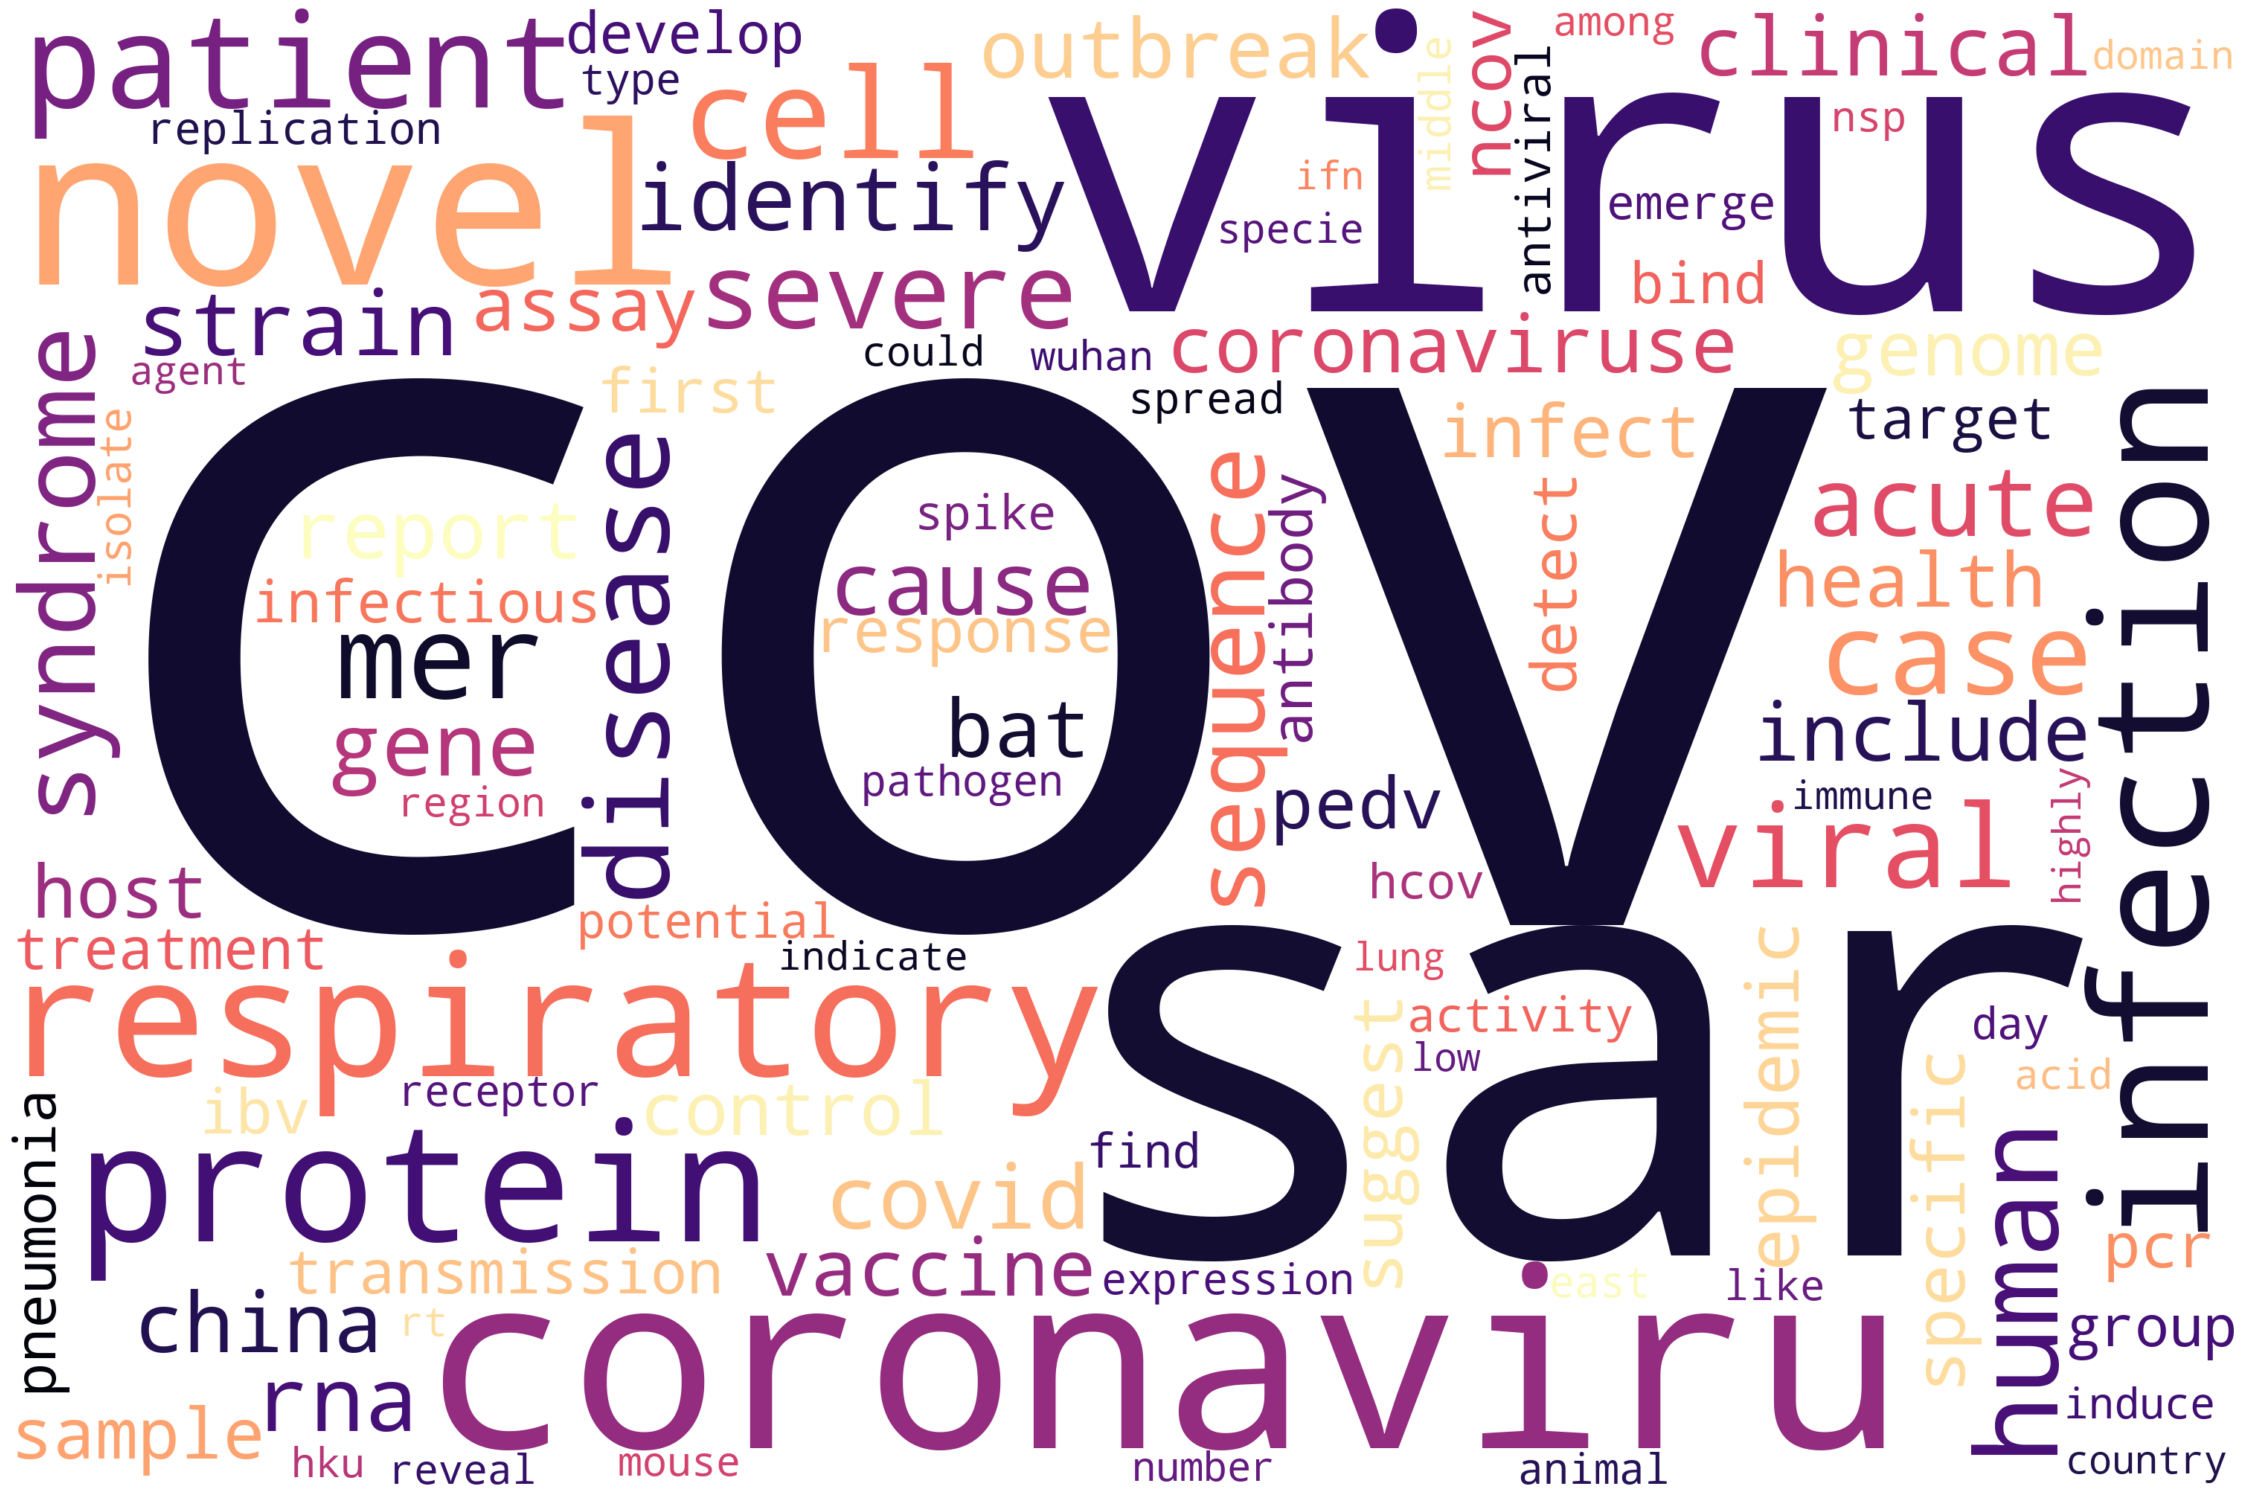

In [34]:
#Word cloud of 100 words in the entire clean text
wordcloud = WordCloud(width = 3000,
    height = 2000,background_color='white',colormap=plt.cm.magma,
                          stopwords=stop_words,
                          max_words=100,
                           
                          random_state=42,collocations=False
                         ).generate(str(clean_text))

#print(wordcloud)
plt.figure(figsize = (40, 30), edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("../data/wordcloud_covid19.png")
plt.show()

In [12]:
stop_words = stopwords.words('english')
print(len(stop_words))
remove_words = ['overall','however', 'confirm','present','perform','attempts', 'model','use', 'calculating','performance','trainable',
                'data','result','representations','using','limited','used','feature','proposed','evaluate'
                ,'performance','algorithm','lr','ext','respective','respectively', 'accuracy', 'relatively'
                ,'small','challenge','validation','layer','better','three','detection','show','cnn','li', 
                'small','show','development','training','transfer','twos','cnns','pre','auroc','two','method',
                'parameters','segmentation','convolutional', 'neural', 'network', 'show','task','compare',
                'state','study', 'retrospective', 'datum','prediction','art','require', 'focus', 'base',
                'approach', 'paper', 'present', 'fall', 'due', 'recent', 'exponential', 'increase','analysis',
                'analysis','specificity','basis', 'function', 'kernel', 'area', 'curve', 'auc', 'may', 
                'useful','explore', 'two', 'different','test','models','system','deep', 'learning',
                'approach','require','may', 'useful','information', 'basis','obtain','methods','achieve',
                'level','al', 'research', 'grid', 'also','features', 'techniques', 'hard', 'parameter', 
                'sharing', 'cross', 'stitch', 'train', 'word', 'level', 'however','search', 'currently',
                'trained','article','analytic','datasets','fold', 'cross', 'propose','compared','based',
                'classification','results','dataset','multiple', 'time','architecture','end', 'sensitivity', 
                'specificity','proive','representation','input','technique','large','work','improve','layers',
                'set','learn','experiment','achieved','information','machine','offers', 'high','networks',
                'superior', 'classification', 'accuracy', 'for', 'automated', 'coding', 'support', 'aid', 'address',
               'available','https','important','role', 'application','good','rate','field','new','tool',
               'subject','value','map','quality','application','provide','one','mr', 'false','positive','tune','fine',
                'github','com','precision','recall','long','short','gold', 'standard','problem','demonstrate','apply',
                'well','truth','ground','similarity','coefficient','entity','event','cohort','molecular','goal','knowledge',
                'refer','conditional','name','natural','language','metho','processing','nlp','term','operate',
                'characteristics', 'whole','slide','supplementary', 'significantly', 'improvement','wide','range',
               'hand','craft','open','source','ci','see','outperform']

#identifies and removes duplicates and returns a lits of words
remove_words= list(set(remove_words))
stop_words.extend(remove_words)
print(len(remove_words))
print(len(stop_words))

179
213
392


In [13]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
minus_stopwords = remove_stopwords(clean_text)

In [14]:
clean_text = [" ".join(x) for x in minus_stopwords]

In [15]:
def text_to_words(text):
    for sentence in text:
        yield(gensim.utils.simple_preprocess(str(sentence)))  # deacc=True removes punctuations

words_text = list(text_to_words(clean_text))

print(words_text[3])

['clinical', 'laboratory', 'differential', 'diagnosis', 'severe', 'form', 'covid', 'definitely', 'establish', 'aim', 'look', 'warn', 'index', 'severe', 'covid', 'patient', 'investigate', 'forty', 'adult', 'patient', 'covid', 'patient', 'classify', 'mild', 'group', 'patient', 'severe', 'group', 'patient', 'comparison', 'haematological', 'mild', 'severe', 'group', 'significant', 'difference', 'il', 'dimer', 'glu', 'tt', 'fib', 'crp', 'optimal', 'threshold', 'roc', 'il', 'pg', 'ml', 'dimer', 'roc', 'il', 'combined', 'dimer', 'predict', 'severity', 'covid', 'il', 'dimer', 'tandem', 'testing', 'il', 'dimer', 'parallel', 'severe', 'covid', 'il', 'dimer', 'closely', 'related', 'occurrence', 'severe', 'covid', 'adult', 'patient', 'combine', 'early', 'severity', 'covid', 'patient', 'clinical', 'protect', 'copyright', 'right', 'reserve']


In [16]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [17]:
lemmatized_words = lemmatization(words_text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [18]:
#clean_text = [" ".join(x) for x in minus_stopwords]

                   Bigram       Freq
0           public health  22.142226
1      infectious disease  19.373097
2            severe acute  16.375012
3         immune response  15.565171
4       respiratory tract  13.917124
5           spike protein  13.635001
6       acute respiratory  13.464480
7              amino acid  13.355971
8   infectious bronchitis  13.287513
9         genome sequence  13.081752
10      respiratory virus  12.672201
11        viral infection  12.241560
12       bronchitis virus  11.599550
13            full length  11.273600
14    respiratory disease  10.920957
15       polymerase chain  10.908220
16            virus virus  10.893676
17         chain reaction  10.717478
18            novel virus  10.621486
19     antiviral activity  10.368916
20  reverse transcription  10.336495
21              cell line   9.777678
22          disease cause   9.506513
23             virus pedv   9.263565
24        causative agent   9.156084
25        severe syndrome   9.128553
2

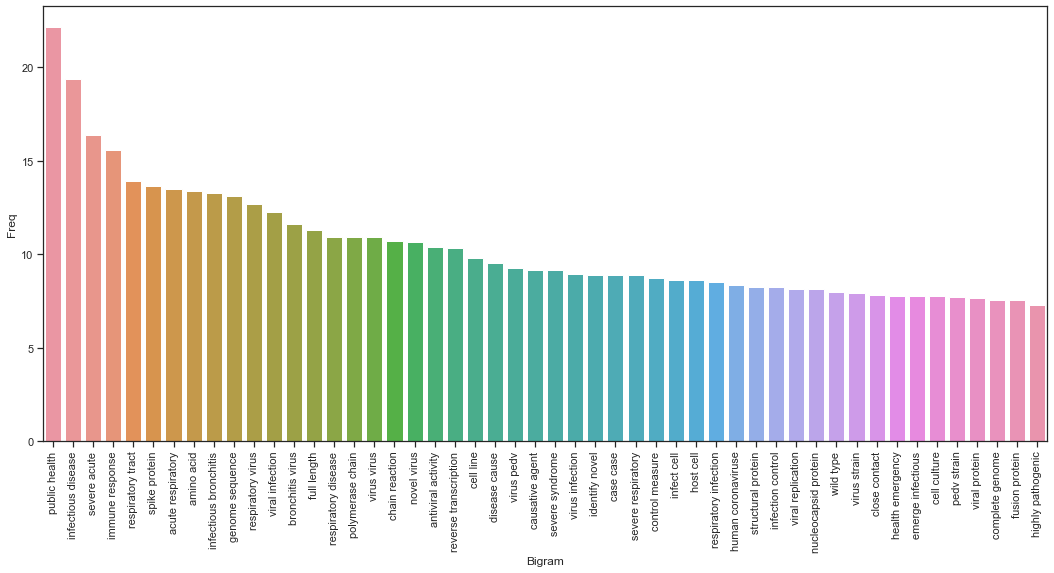

In [19]:
#Most frequently occuring bigrams in the data. plot both bar plot and word cloud of bigrams in the data 
def top_bi_grams(clean_text, n=None):
    clean_text = [" ".join(x) for x in lemmatized_words]
    vectorizer = TfidfVectorizer(ngram_range = (2,2), min_df = 2,stop_words=stop_words).fit(clean_text)
    bows = vectorizer.transform(clean_text)
    sumwords = bows.sum(axis=0) 
    words_freq = [(word, sumwords[0, idx]) for word, idx in     
                  vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top_bigrams = top_bi_grams(clean_text, n=50)
top_bigrams_df = pd.DataFrame(top_bigrams)
top_bigrams_df.columns=["Bigram", "Freq"]
print(top_bigrams_df)

#Barplot of most freq Bi-grams
sns.set(rc={'figure.figsize':(18,8)}, style ='white' )
sns.set_style("ticks")

h=sns.barplot(x="Bigram", y="Freq", data=top_bigrams_df)
h.set_xticklabels(h.get_xticklabels(), rotation=90);

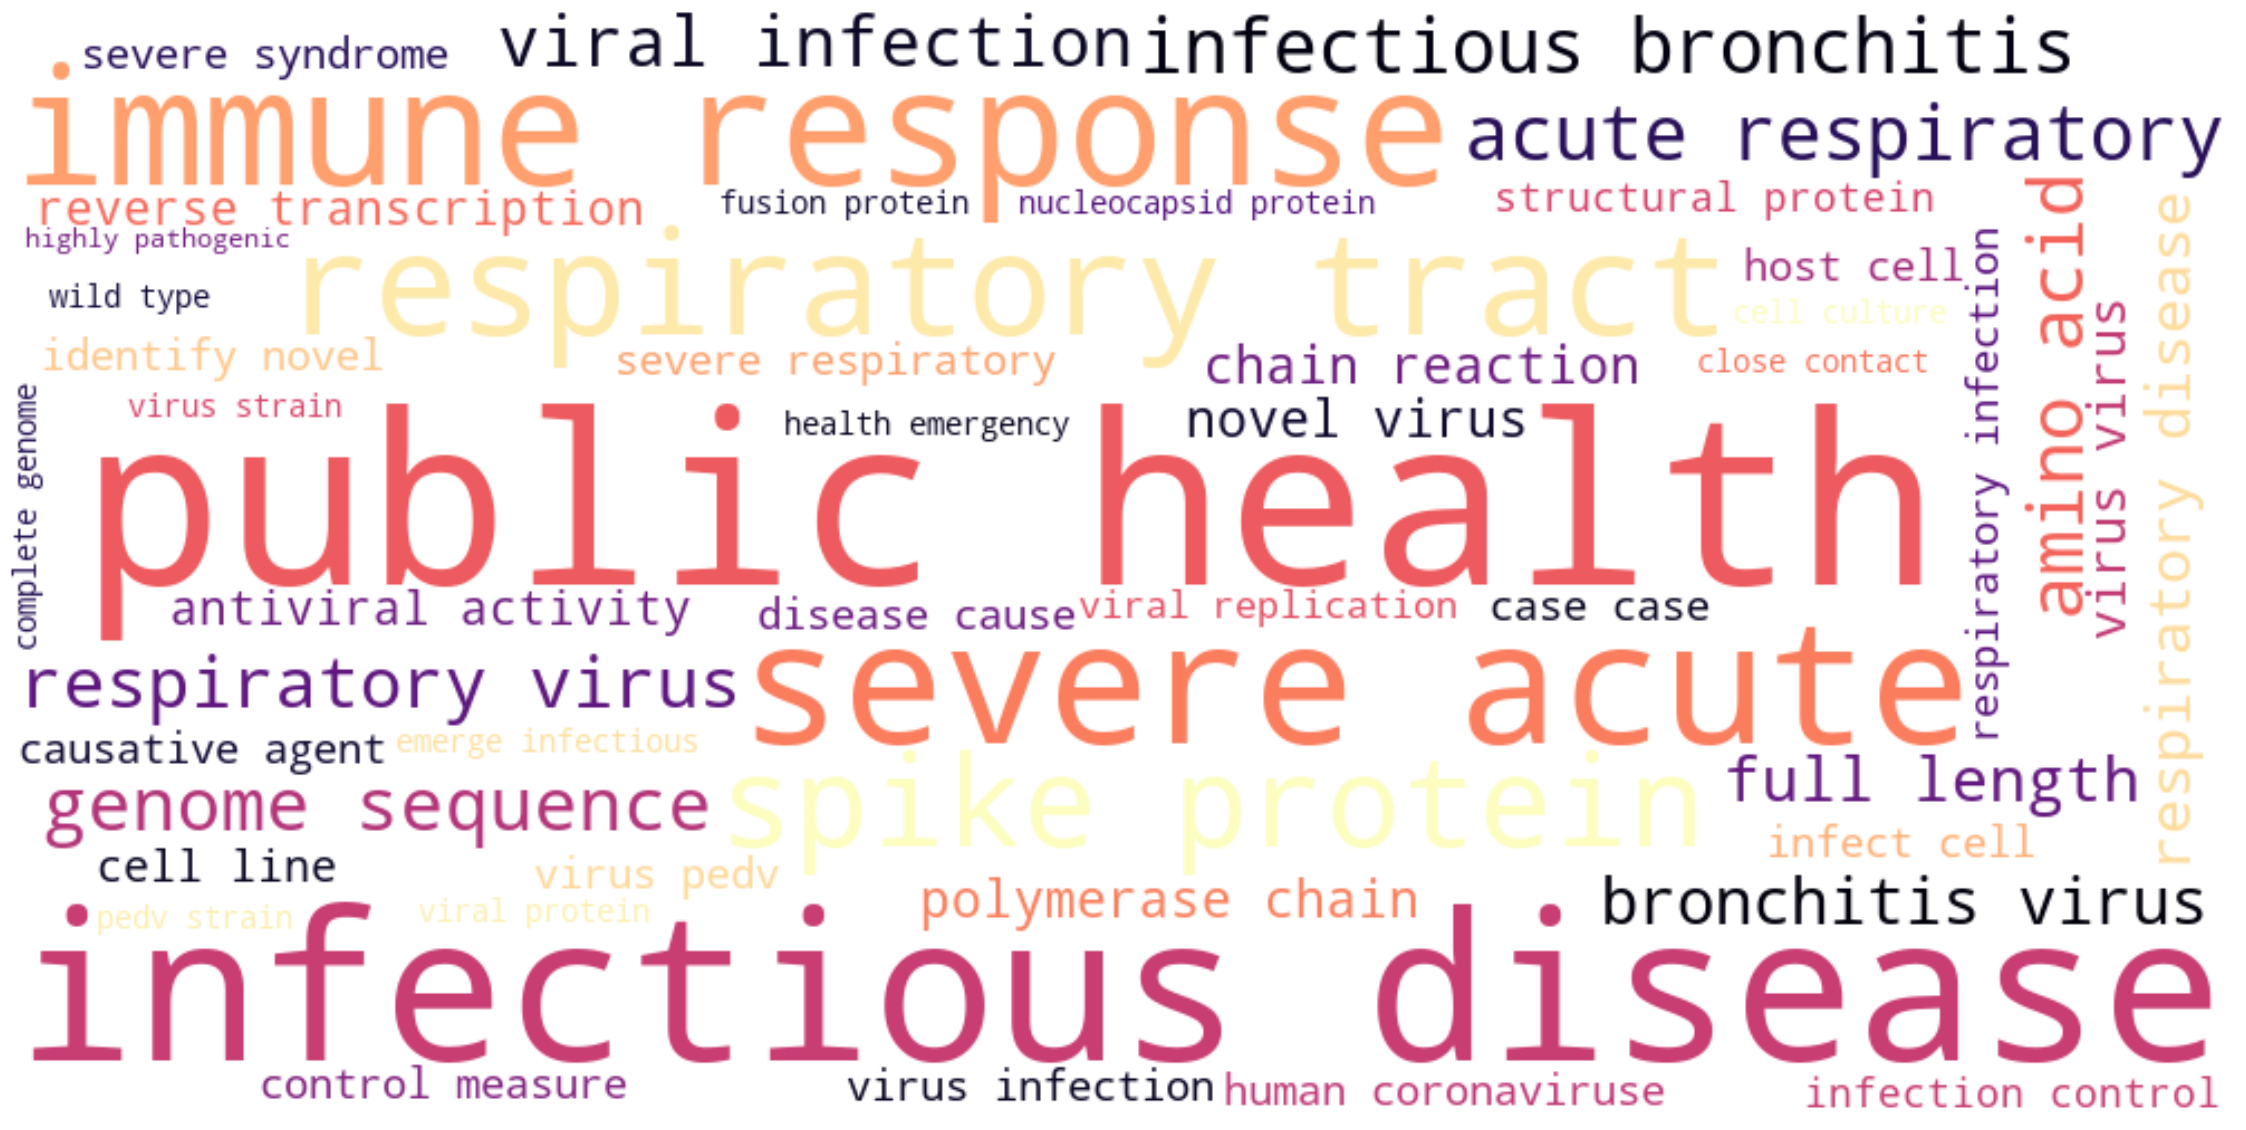

In [20]:
bigrams = {}
for w, x in top_bigrams_df.values:
    bigrams[w] = x
wordcloud = WordCloud(width = 1000,
    height = 500,background_color='white',colormap=plt.cm.magma,margin=5,
                      relative_scaling=1, collocations=False)
wordcloud.generate_from_frequencies(bigrams)
plt.figure(figsize = (40, 30),
    
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("../data/word_cloud_covid19.png", bbox_inches='tight')
plt.show()

In [21]:
bigram = Phrases(lemmatized_words, min_count=1, threshold=100)
trigram = Phrases(lemmatized_words, min_count=1, threshold=100)
bigrams_mod = Phraser(bigram)
trigrams_mod = Phraser(trigram)

In [22]:
def bigrams(texts):
    return [bigrams_mod[doc] for doc in texts]
words_bigrams = bigrams(lemmatized_words)

def trigrams(texts):
    return [trigrams_mod[doc] for doc in texts]
words_trigrams = trigrams(lemmatized_words)

In [23]:
# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     """https://spacy.io/api/annotation"""
#     texts_out = []
#     for sent in texts:
#         doc = nlp(" ".join(sent)) 
#         texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#     return texts_out

In [24]:
#data_lemme = lemmatization(words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [25]:
# Create Dictionary
id2word = corpora.Dictionary(words_bigrams)


# Create Corpus
texts = words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:2])


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)], [(7, 1), (12, 2), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 3), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 1)]]


In [26]:
id2word[21]

'course'

In [27]:
# Build LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=14, 
                     random_state=100,
                     update_every=1,
                     chunksize=1000,
                     passes=25,
                     alpha='auto',
                     per_word_topics=True)

In [28]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.097*"protein" + 0.028*"sequence" + 0.017*"viral" + 0.017*"virus" + '
  '0.016*"domain" + 0.016*"site" + 0.014*"cell" + 0.012*"contain" + '
  '0.012*"gene" + 0.011*"fusion"'),
 (1,
  '0.048*"pro" + 0.031*"shape" + 0.023*"proteolytic" + 0.010*"differentiation" '
  '+ 0.010*"replacement" + 0.009*"silence" + 0.009*"humoral_cellular" + '
  '0.009*"bud" + 0.008*"heptad_repeat" + 0.008*"dramatic"'),
 (2,
  '0.022*"virus" + 0.021*"vaccine" + 0.017*"response" + 0.014*"epitope" + '
  '0.014*"novel" + 0.012*"viral" + 0.012*"potential" + 0.012*"strategy" + '
  '0.011*"develop" + 0.011*"human"'),
 (3,
  '0.027*"pair" + 0.024*"percent" + 0.013*"loop" + 0.012*"dimer" + '
  '0.011*"papain_protease" + 0.011*"bovine" + 0.009*"oral" + 0.009*"terminus" '
  '+ 0.009*"fluorescence" + 0.008*"label"'),
 (4,
  '0.031*"antiviral" + 0.029*"activity" + 0.022*"drug" + 0.019*"target" + '
  '0.017*"severe" + 0.017*"compound" + 0.015*"agent" + 0.012*"type" + '
  '0.012*"therapeutic" + 0.012*"disease"'),
 (5

In [29]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.8010655400874285

Coherence Score:  0.5081618663096721


In [30]:
# code repurposed from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

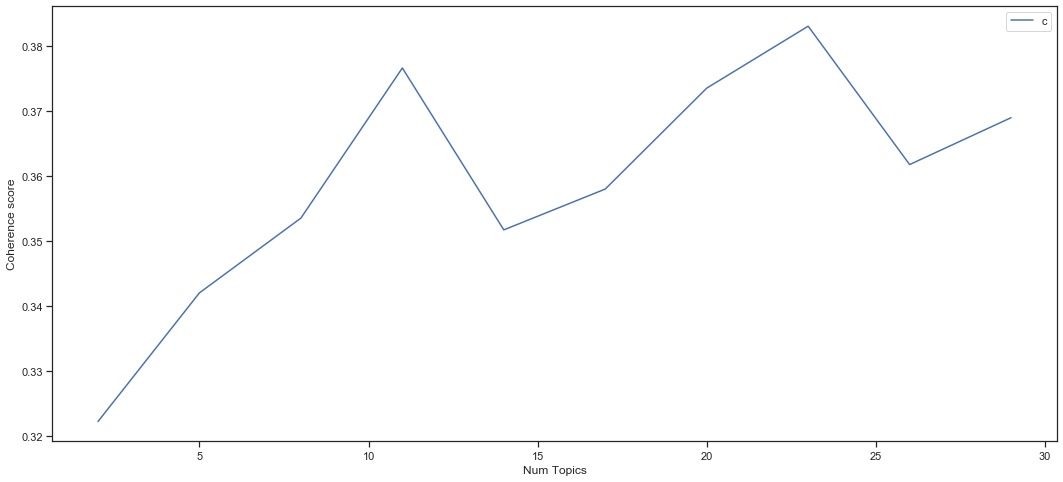

In [31]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=words_bigrams, start=2, limit=30, step=3)
# Show graph

limit=30; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [32]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.083367  0.199759       1        1  15.303270
12     0.197506 -0.000969       2        1  14.713558
8      0.188064 -0.095732       3        1  11.732062
0      0.193650 -0.213776       4        1  11.540377
2      0.115512 -0.042951       5        1  10.167549
10     0.125250 -0.110393       6        1   8.601874
9      0.085635  0.231609       7        1   7.770533
7      0.005388  0.171144       8        1   6.882730
4      0.085794 -0.035417       9        1   6.138627
5     -0.092519  0.041592      10        1   2.833179
13    -0.189918  0.123295      11        1   2.286516
3     -0.263887 -0.103425      12        1   1.073574
6     -0.268325 -0.086073      13        1   0.620788
1     -0.265517 -0.078662      14        1   0.335365, topic_info=     Category         Freq         Term        Total  loglift  logprob
182   Default  1729.000000         cell  1729.000000  30.0000  30.0000
209   Default  1957.000000      protein  1957.000000  29.0000  29.0000
37    Default  1496.000000      patient  1496.000000  28.0000  28.0000
688   Default   815.000000       strain   815.000000  27.0000  27.0000
16    Default  1160.000000         case  1160.000000  26.0000  26.0000
...       ...          ...          ...          ...      ...      ...
1567  Topic14     1.841906  participant     9.793911   4.0267  -5.5626
1550  Topic14     2.250368     resemble    23.465424   3.3533  -5.3623
745   Topic14     3.441466       active   124.182701   2.1118  -4.9375
1629  Topic14     1.608586   disruption    10.334222   3.8376  -5.6981
4388  Topic14     1.430669  serological    31.682499   2.6001  -5.8153

[914 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1296      2  0.081499      ability
1296      3  0.488992      ability
1296      5  0.172053      ability
1296      6  0.009055      ability
1296      8  0.009055      ability
...     ...       ...          ...
5627     10  0.933753  young_child
2457      2  0.542810     zoonotic
2457      5  0.042853     zoonotic
2457      7  0.042853     zoonotic
2457     10  0.357112     zoonotic

[1838 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 13, 9, 1, 3, 11, 10, 8, 5, 6, 14, 4, 7, 2])

In [33]:
pyLDAvis.save_html(vis, '../data/ldacovid.html')